# Network Analysis - City Bike

Helsinki City Bikes are shared bicycles available to the public in Helsinki and Espoo metropolitan areas.
The city bikes were introduced in 2016 as a pilot project with only 46 bike stations available in Helsinki. After becoming very popular the system was expanded and by 2019 the bike network reached its complete state with only 7 stations being added in 2020. As of 2020, there were 3,510 bikes and 350 stations.
In order to use the city bikes, citizens purchase access for a day, week or the entire cycling season that lasts from April to November. All passes include an unlimited number of 30-minute bike rides. For an extra fee of 1€/hour, you can use the bike for longer. Bikes are picked up and returned to stations that are located all around Helsinki and Espoo.

In [12]:
import datetime
import calendar
import collections

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import networkx as nx
import community as community_louvain
from operator import itemgetter

import folium
from folium import plugins

import seaborn as sns
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

## EDA 

In [3]:
df = pd.read_csv("Downloads/database.csv")
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


departure               return departure_id    departure_name  \
0  2020-03-23 06:09:44  2020-03-23 06:16:26           86          Kuusitie   
1  2020-03-23 06:11:58  2020-03-23 06:26:31           26        Kamppi (M)   
2  2020-03-23 06:16:29  2020-03-23 06:24:23          268  Porolahden koulu   
3  2020-03-23 06:33:53  2020-03-23 07:14:03          751        Vallipolku   
4  2020-03-23 06:36:09  2020-03-23 07:04:10           62  Länsisatamankatu   

  return_id       return_name  distance (m)  duration (sec.)  \
0     111.0     Esterinportti        1747.0            401.0   
1      10.0       Kasarmitori        1447.0            869.0   
2     254.0       Agnetankuja        1772.0            469.0   
3     106.0   Korppaanmäentie        7456.0           2406.0   
4     121.0  Vilhonvuorenkatu        7120.0           1679.0   

   avg_speed (km/h)  departure_latitude  departure_longitude  return_latitude  \
0          0.261397           60.195245            24.901900        60.197572   
1          0.099908           60.168610            24.930537        60.165017   
2          0.226695           60.195540            25.053581        60.187234   
3          0.185935           60.227827            24.819614        60.203474   
4          0.254437           60.158928            24.909692        60.186463   

   return_longitude  Air temperature (degC)  
0         24.926781                     0.9  
1         24.949473                     0.9  
2         25.036412                     0.9  
3         24.898930                     0.9  
4         24.967872                     0.9

After a look on the dataset, I transform the columns that refer to time in date time format and also drop the Na values. Then I rename some columns to be more clear.

In [4]:
# Convert timestamp to datetime64[ns]
df[['departure','return']] =  df[['departure','return']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
df.dropna(inplace=True)

In [5]:
df = df.rename(columns={'distance (m)': 'Distance',
                                     'duration (sec.)': 'Duration',
                                     'avg_speed (km/h)':'Speed',
                                      'Air temperature (degC)':'Temperature',
                                     })

I find an interesting code on internet to check some errors in large datasets. In fact we can notice that we have some strange values for distances, for this reason I then filter the dataset for a minimun distance of 50 and a maximum of 10.000 meters and the same for the duration 120 seconds and 18.000 seconds (5 hours).

In [6]:
# Code to analyze if we have some errors in the dataset
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df[["Distance", "Duration", "Temperature"]].describe()

Distance     Duration  Temperature
count 12138008.000 12138008.000 12138008.000
mean      2296.183      960.187       15.650
std      24540.204     7351.542        5.498
min   -4292467.000        1.000       -5.200
25%       1000.000      344.000       12.300
50%       1739.000      586.000       16.400
75%       2869.000      971.000       19.300
max    3681399.000  5401659.000       32.900

In [14]:

df = df[ (50 < df['Distance']) & (df['Distance'] < 10000) &
        (120 < df['Duration']) & (df['Duration'] <  18000)]

df[["Distance", "Duration"]].describe()

Distance     Duration
count 11278849.000 11278849.000
mean      2242.385      783.600
std       1494.708      795.838
min         51.000      121.000
25%       1121.000      380.000
50%       1847.000      615.000
75%       2964.000      991.000
max       9999.000    17998.000

In [10]:
df2 = df.copy()

In [11]:
df2 = df.copy()
df2["Duration"]=df2["Duration"]/60

After those things I start looking at the data with histograms for duration and distance.

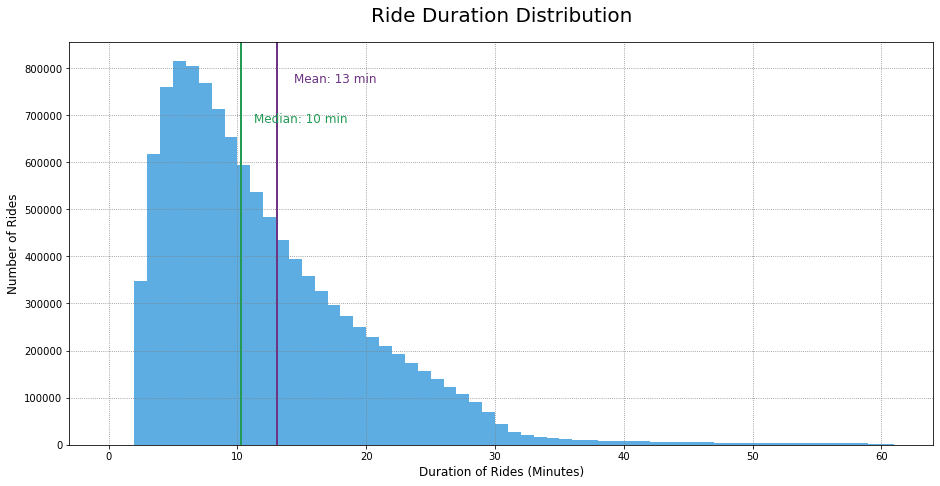

In [12]:
# HISTOGRAMS
    
# Filtering relevant data
duration_data = df2["Duration"]
fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Ploting the histogram
plt.hist(duration_data, bins= range(62), color = BLUE, histtype ="bar")

# Adding median and mean lines
plt.axvline(df2["Duration"].mean(), color=MAGENTA, linestyle='-', linewidth=2 )
plt.axvline(df2["Duration"].median(), color=GREEN, linestyle='-', linewidth=2 )

# Adding median and mean texts
min_ylim, max_ylim = plt.ylim()
plt.text(df2["Duration"].mean()*1.1, max_ylim*0.9, 'Mean: {:.0f} min'.format(df2["Duration"].mean()), color = MAGENTA,  fontsize= 12)
plt.text(df2["Duration"].median()*1.1, max_ylim*0.8, 'Median: {:.0f} min'.format(df2["Duration"].median()), color = GREEN, fontsize= 12)
    
# Label
ax.set_title('Ride Duration Distribution', fontdict={"fontsize":20}, pad = 20)
plt.xlabel("Duration of Rides (Minutes)", fontsize= 12, x = 0.5)
plt.ylabel("Number of Rides", fontsize= 12)

ax.set_title('Ride Duration Distribution', fontdict={"fontsize":20}, pad = 20)
plt.xlabel("Duration of Rides (Minutes)", fontsize= 12, x = 0.5)
plt.ylabel("Number of Rides", fontsize= 12)

# Adding Grid
plt.grid(linestyle=":", color='grey')


plt.show()

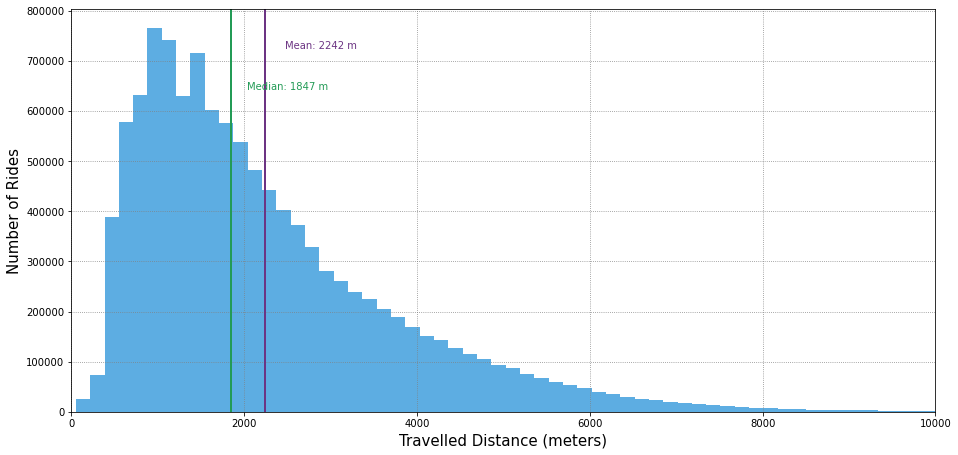

In [13]:
# Same thing with distance
data = df2["Distance"]
fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.hist(data, bins = 60, color = BLUE)


plt.axvline(df2["Distance"].mean(), color=MAGENTA, linestyle='-', linewidth=2 )
plt.axvline(df2["Distance"].median(), color=GREEN, linestyle='-', linewidth=2 )

min_ylim, max_ylim = plt.ylim()

plt.text(df2["Distance"].mean()*1.1, max_ylim*0.9, 'Mean: {:.0f} m'.format(df2["Distance"].mean()), color = MAGENTA,  fontsize= 10)
plt.text(df2["Distance"].median()*1.1, max_ylim*0.8, 'Median: {:.0f} m'.format(df2["Distance"].median()), color = GREEN, fontsize= 10)

ax.set_xlim([0,10000])
    
# Labeling Axes
plt.xlabel("Travelled Distance (meters)", fontsize= 15, x = 0.5)
plt.ylabel("Number of Rides", fontsize= 15)

# Adding Grid
plt.grid(linestyle=":", color='grey')

plt.show()

After I have a look of the number of trips over the years. Then I plot a matrix with the days and the hours of a day, the colors represents the number of trips in that hour for that day.

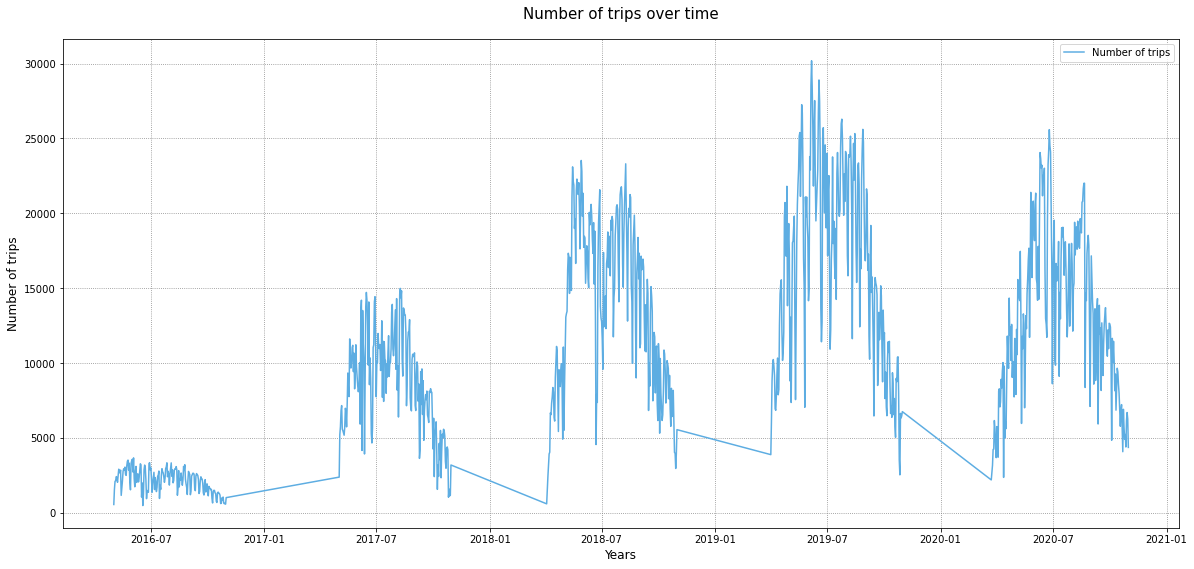

In [14]:
## Number of trips over the years
df3 = df.copy()
df_over_time = df3.groupby(df3['departure'].dt.date).size().reset_index(name='count')

# Figure
fig, ax = plt.subplots(figsize=(20,9))
plt.plot(df_over_time["departure"], df_over_time["count"], color= BLUE)

# Labels
ax.set_title("Number of trips over time", fontsize= 15, pad= 20)
ax.set_ylabel("Number of trips", fontsize=12)
ax.set_xlabel("Years", fontsize=12)

# Grid & Legend
plt.grid(linestyle=":", color='grey')
plt.legend(["Number of trips"])

plt.show()

Text(114.0, 0.5, 'Day of the week')

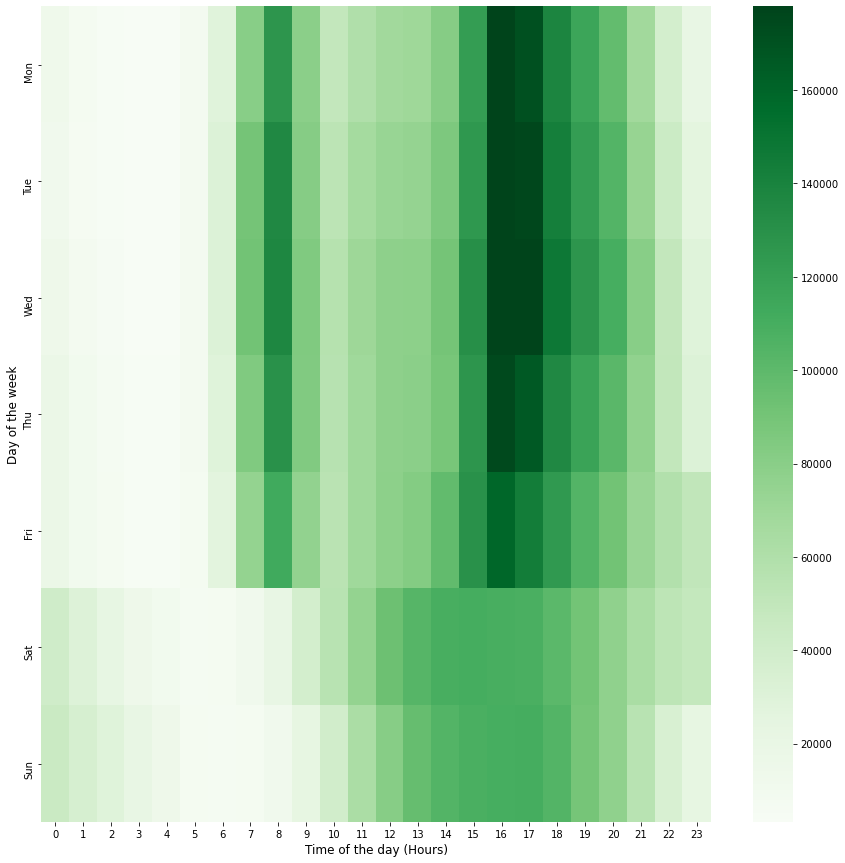

In [15]:
weekdays = ["Mon", "Tue","Wed", "Thu", "Fri", "Sat", "Sun"]
    
# Data
df4 = df.copy()
df4["hour"] = pd.DatetimeIndex(df4['departure']).hour
df4["weekday"] = pd.DatetimeIndex(df4['departure']).weekday
daily_activity = df4.groupby(by=['weekday','hour']).count()['departure_name'].unstack()

# Figure
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(daily_activity, robust=True, cmap="Greens", yticklabels=weekdays) # "YlOrBr


# Labeling Axes
plt.xlabel("Time of the day (Hours)", fontsize= 12, x = 0.5)
plt.ylabel("Day of the week", fontsize= 12)

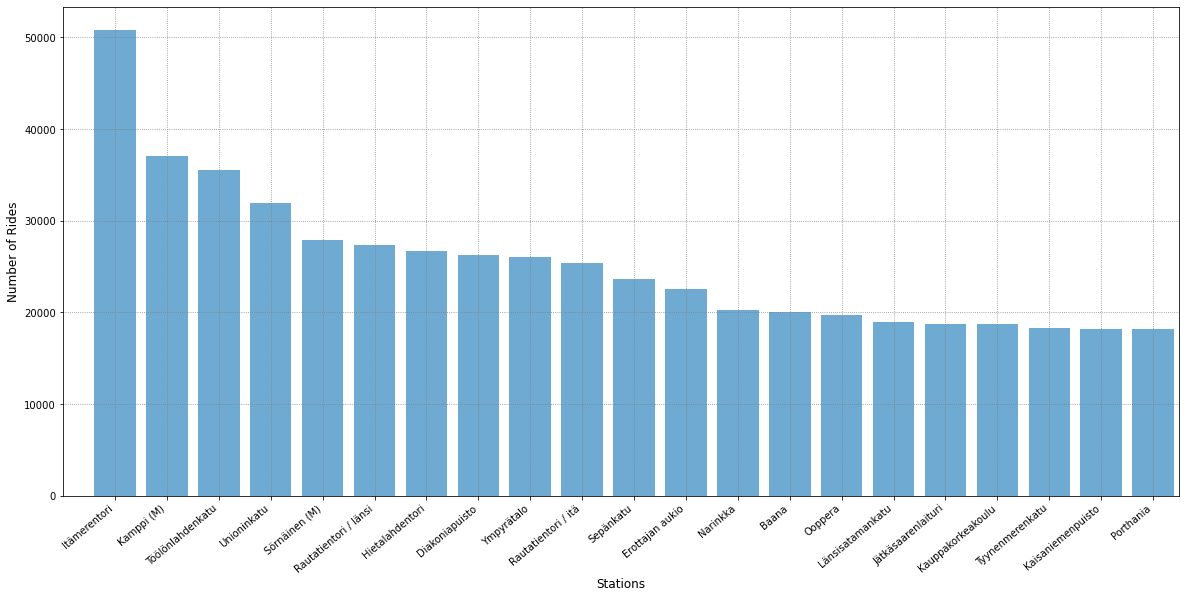

In [24]:
# Top stations by departure
# Data
df5 = df.copy()
df5 = df5[df5['departure'].dt.year == 2017]

# Figure
fig = plt.figure(figsize=(20,9))
ax = sns.countplot(x="departure_name", color = BLUE, data=df5, order = df5['departure_name'].value_counts().index)

# Labeling Axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel("Stations", fontsize= 12, x = 0.5)
plt.ylabel("Number of Rides", fontsize= 12)
plt.xlim(-1,20.5)

# Adding Grid
plt.grid(linestyle=":", color='grey')

# Analysis

Now we create the graph network, taking into account only the 2020.

<ipython-input-8-c7bd499fde8c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6.dropna(inplace=True)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (2,4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


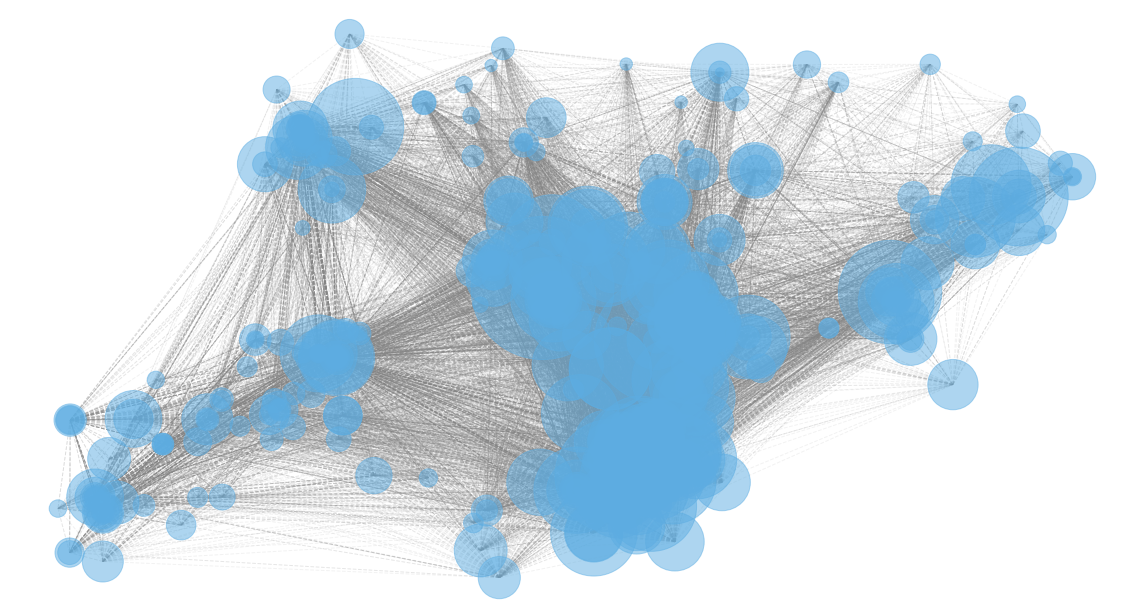

In [8]:
def Network(df, year=2020):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df6 = df.copy()
    df6 = df[df['departure'].dt.year == year]
    df6.dropna(inplace=True)
    
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df6, 'departure_name', 'return_name', edge_attr=['Duration','Distance'])

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))
    stantions  = pd.read_csv("Downloads/database.csv")
    stantions.set_index('return_name',inplace=True)
    stantions["pos"] = list(zip(stantions["departure_longitude"].astype(float), stantions["departure_latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=BLUE, alpha=0.5, node_size= (df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dashed", alpha=0.1, arrows=False)
    ax.axis('off')
    
   
    
    return G
G=Network(df)

I calculate the top 5 nodes for betweeness centrality and degree centrality 

In [16]:
def Stats(G):
    """
    This function prints the basic properties of the City bike network.
    """
    print(nx.info(G))
    density = nx.density(G)
    print("Network density:", density)
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    
    #Top 5 by degree
    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G) # Compute eigenvector centrality

    # Top 5 betweennes
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G) # Compute eigenvector centrality

    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)
    # Top 5 eigen
    sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G) # Compute eigenvector centrality

    sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by eigenvector centrality:\n")
    for b in sorted_eigenvector[:5]:
        print(b)
Stats(G)

Name: 
Type: Graph
Number of nodes: 347
Number of edges: 29604
Average degree: 170.6282
Network density: 0.49314520830904035
Triadic closure: 0.7490986589530844

Top 5 nodes by degree:

('Haukilahdenkatu', 312)
('Paciuksenkaari', 272)
('Huopalahdentie', 267)
('Laajalahden aukio', 262)
('Munkkiniemen aukio', 262)

Top 5 nodes by betweenness centrality:

('Haukilahdenkatu', 0.049350760236088746)
('Lehtisaarentie', 0.0071203742710766035)
('Lauttasaaren ostoskeskus', 0.006137945150459285)
('Aalto-yliopisto (M), Korkeakouluaukio', 0.005792495359391806)
('Paciuksenkaari', 0.005688626807042346)

Top 5 nodes by eigenvector centrality:

('Haukilahdenkatu', 0.08137256401654606)
('Töölöntulli', 0.0781367824091642)
('Paciuksenkaari', 0.07800938857639494)
('Pasilan asema', 0.07794900250006993)
('Huopalahdentie', 0.07772448667401602)


Eigen vector centrality can be misleading do to the presence of a lots of external factors that can make a node important.

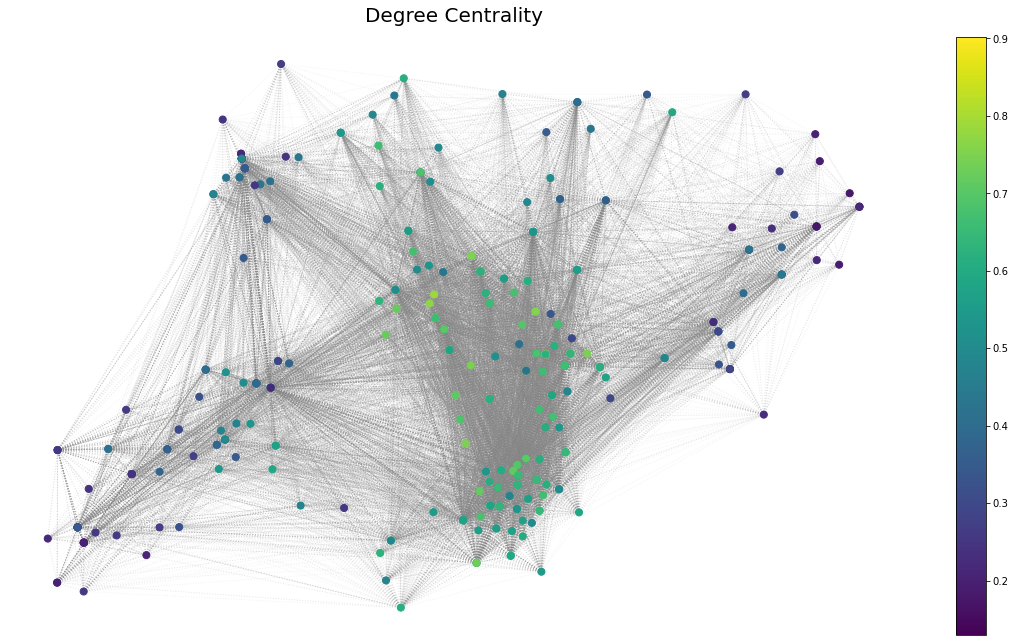

In [17]:
def Degree(G):
    """
    Plot network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')



# function call is commented for performance reason
Degree(G)

Then I plot the degree distribution.

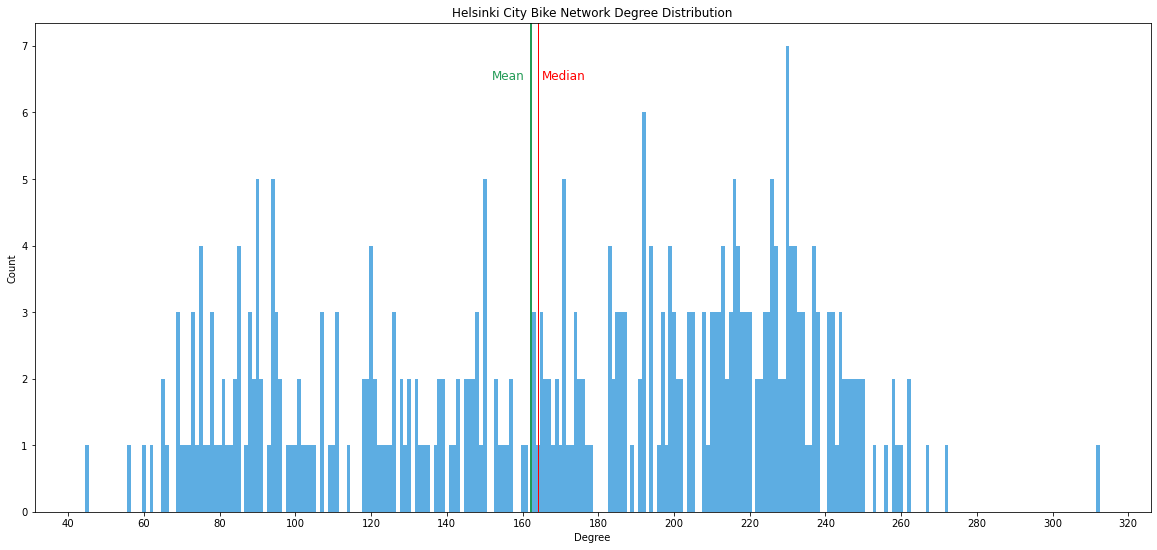

In [22]:
def centralityDegreeDist(G):
    """
    Centrality degree distribution
    """
    # Degree
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    # Figure
    fig, ax = plt.subplots(figsize=(20,9))
    plt.bar(deg, cnt, width=1, color=BLUE)
    plt.axvline(x = sum(deg)/len(deg), color=GREEN, linestyle='-', linewidth=2) # Degree Mean
    plt.axvline(x = np.median(deg), color="red", linestyle='-', linewidth=1) # Degree Median

    # Labeling
    plt.title("Helsinki City Bike Network Degree Distribution")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.text(x= 152,y=6.5, s="Mean", color = GREEN, fontsize= 12)
    plt.text(x= 165,y=6.5, s="Median", color = "red", fontsize= 12)
    ax.set_xticks(range(40,340,20))

    plt.show()
    
centralityDegreeDist(G)

Same thing for the betweeness centrality.

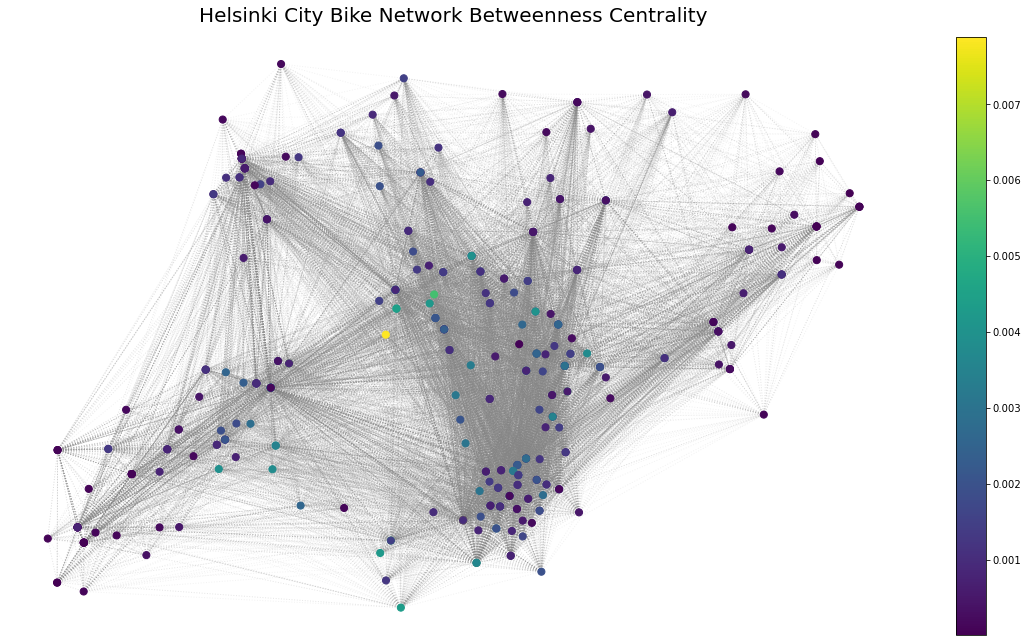

In [23]:
def Betweenness(Graph): 
    """
    Plot by betweenes centrality
    """
    
    G = Graph.copy(as_view=False)
    G.remove_node("Haukilahdenkatu")
        
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))
    
   

    betweenness = nx.betweenness_centrality(G)
    node_color = [betweenness[i] for i in betweenness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color) - (sum(node_color)/len(node_color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Betweenness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')




Betweenness(G)

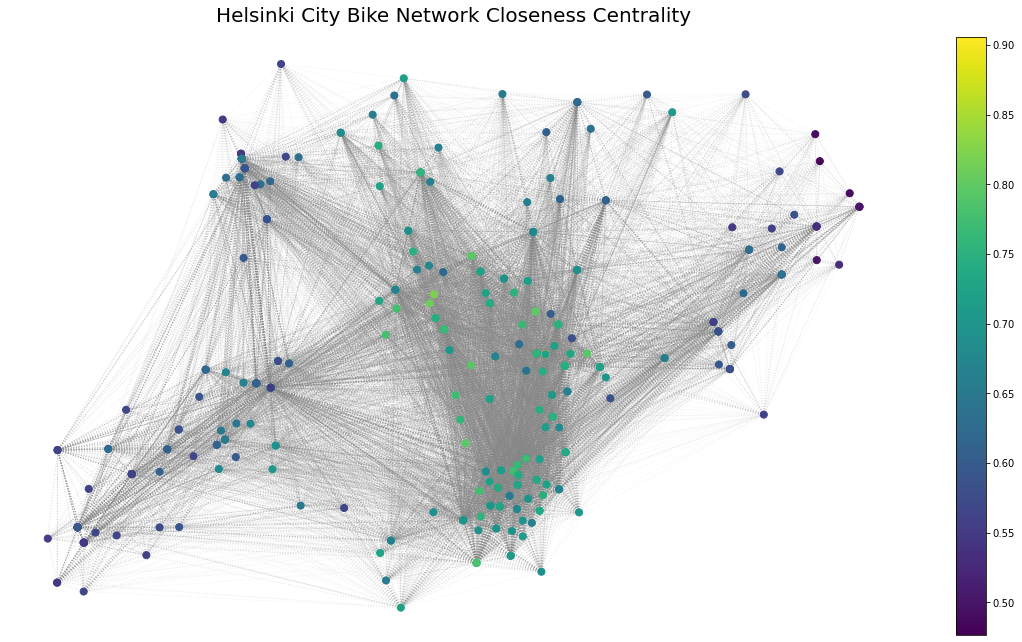

In [24]:
def Closeness(G):
    """
    Plot by Closeness
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    closeness = nx.closeness_centrality(G)
    node_color = [closeness[i] for i in closeness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Closeness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')
    
Closeness(G)


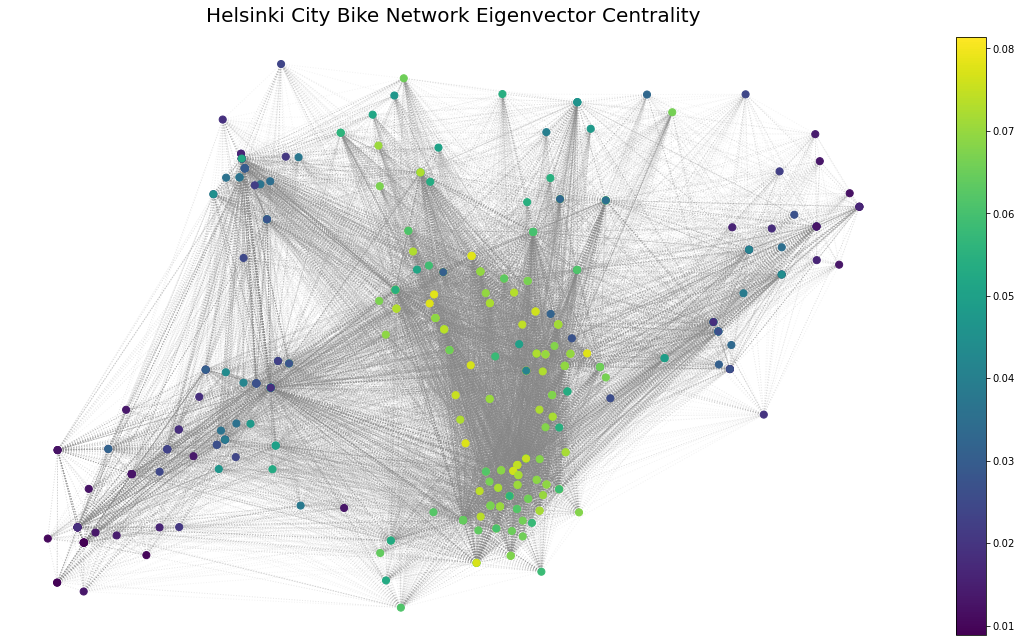

In [25]:
def Eigenvector(G):
    """
    Plot by Eigenvector centrality
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    eigenvector = nx.eigenvector_centrality(G, max_iter=6000, weight="duration")
    node_color = [eigenvector[i] for i in eigenvector.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Eigenvector Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')
Eigenvector(G)


After the analysis of the most common measures I apllied a community detection.

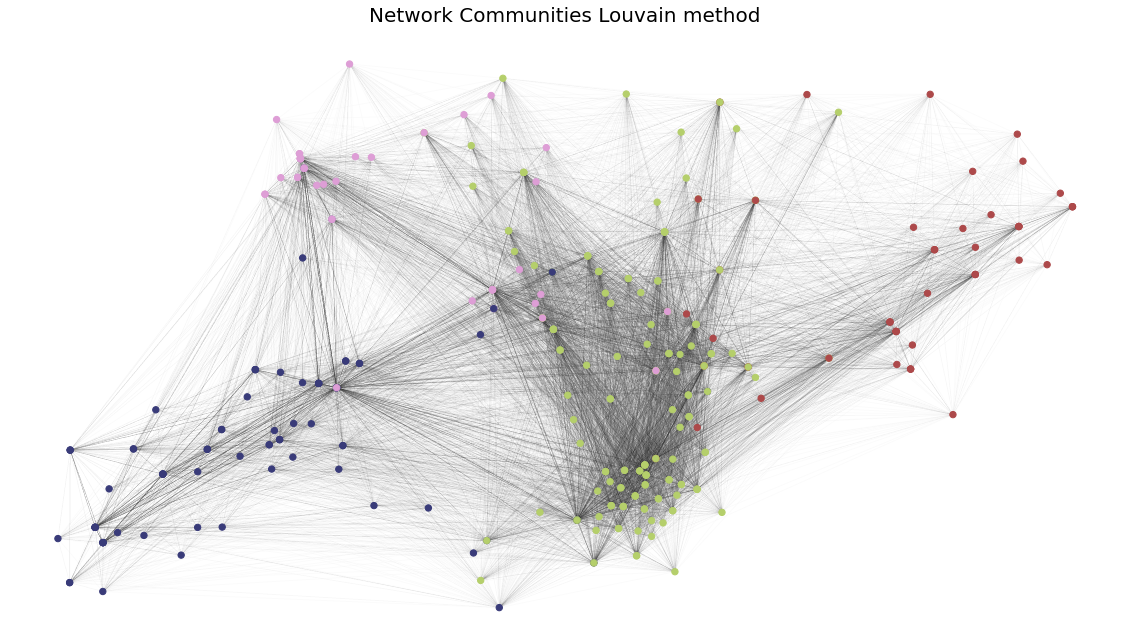

In [17]:
def Louvain(G):
    """
    This function applies the Louvain method for community detection on the City bike network.
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute Louvain method
    partition = community_louvain.best_partition(G, resolution=0.95, random_state=1)

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.015)

    # Labeling Axes
    ax.set_title('Network Communities Louvain method', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')
    plt.show()
    
Louvain(G)